# US Housing Market Analysis

In [1]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
from bokeh.io import export_png
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Loading and cleaning data
We will be using data from [FRED](https://fred.stlouisfed.org/), the Federal Reserve Economic Data, and [AlphaVantage](https://www.alphavantage.co/), a free API for stock market data. The data collected from AlphaVantage is mostly commodity prices, and the data from FRED is mostly economic indicators. 

In [2]:
# Read in data
file_path = Path("data/housing_data3.csv")
df = pd.read_csv(file_path)
df.head()

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
0,1987-01-01,63.734,6.0,1690.0,90.4,1090.0,1774.0,108.1,58585,125.90971,1862.0,97900.0,18.65,111.2,6.43,384.227143,-0.506
1,1987-02-01,64.134,6.2,1689.0,90.2,1096.0,1784.0,109.4,53102,124.24761,1771.0,97900.0,17.75,111.6,6.10,411.712632,-0.495
2,1987-03-01,64.469,6.0,1704.0,90.8,1084.0,1726.0,110.6,43500,123.59781,1694.0,97900.0,18.30,112.1,6.13,432.204545,-0.335
3,1987-04-01,64.973,6.0,1601.0,92.8,1079.0,1614.0,110.7,54405,134.50752,1735.0,103400.0,18.68,112.7,6.37,422.771429,0.105
4,1987-05-01,65.547,6.7,1500.0,91.1,1070.0,1628.0,110.7,65151,144.95212,1713.0,103400.0,19.44,113.1,6.85,416.634000,0.540


In [3]:
df.tail()

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
428,2022-09-01,300.451,9.7,1588.0,58.6,1698.0,1463.0,322.849,72386,83.61149,1438.0,468000.0,84.26,296.81,2.56,11402.850000,-0.1320
429,2022-10-01,298.672,9.7,1555.0,59.9,1710.0,1432.0,317.617,65599,94.39124,1348.0,479500.0,87.55,298.01,3.08,10801.494286,-0.0925
430,2022-11-01,296.809,9.4,1402.0,56.8,1695.0,1427.0,312.864,55272,93.09166,1543.0,479500.0,84.37,297.71,3.78,10973.638095,-0.1725
431,2022-12-01,294.266,8.5,1409.0,59.7,1696.0,1357.0,308.076,47749,87.05882,1390.0,479500.0,76.44,296.80,4.10,10838.995714,-0.1960
432,2023-01-01,292.444,8.1,1354.0,64.9,1695.0,1340.0,306.461,40292,85.80711,1377.0,436800.0,78.12,299.17,4.33,11013.991000,-0.2825


In [4]:
# create a new column called 'Price Change' and set the values to 0 if the value of the 'Price Index' column is less than the value of the previous row, otherwise set the value to 1
df["Price Change"] = np.where(df["Price Index"] < df["Price Index"].shift(1), 0, 1)
df.tail(10)

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI,Price Change
423,2022-04-01,301.789,8.5,1795.0,65.2,1669.0,1803.0,356.444,73334,68.16005,1361.0,449300.0,101.78,289.11,0.33,13394.163000,-0.3320,1
424,2022-05-01,306.569,8.3,1708.0,58.4,1680.0,1543.0,358.834,83758,71.54583,1446.0,449300.0,109.55,292.30,0.77,11829.729524,-0.2525,1
425,2022-06-01,308.334,9.5,1701.0,50.0,1688.0,1561.0,334.275,87679,75.54036,1392.0,449300.0,114.84,296.31,1.21,11418.919048,-0.1725,1
426,2022-07-01,307.135,10.1,1658.0,51.5,1683.0,1371.0,331.669,85499,74.04241,1396.0,468000.0,101.62,296.28,1.68,11622.631500,-0.1660,0
427,2022-08-01,303.649,8.7,1586.0,58.2,1702.0,1505.0,329.173,81651,71.44323,1355.0,468000.0,93.67,296.17,2.33,12570.260435,-0.2275,0
428,2022-09-01,300.451,9.7,1588.0,58.6,1698.0,1463.0,322.849,72386,83.61149,1438.0,468000.0,84.26,296.81,2.56,11402.850000,-0.1320,0
429,2022-10-01,298.672,9.7,1555.0,59.9,1710.0,1432.0,317.617,65599,94.39124,1348.0,479500.0,87.55,298.01,3.08,10801.494286,-0.0925,0
430,2022-11-01,296.809,9.4,1402.0,56.8,1695.0,1427.0,312.864,55272,93.09166,1543.0,479500.0,84.37,297.71,3.78,10973.638095,-0.1725,0
431,2022-12-01,294.266,8.5,1409.0,59.7,1696.0,1357.0,308.076,47749,87.05882,1390.0,479500.0,76.44,296.80,4.10,10838.995714,-0.1960,0
432,2023-01-01,292.444,8.1,1354.0,64.9,1695.0,1340.0,306.461,40292,85.80711,1377.0,436800.0,78.12,299.17,4.33,11013.991000,-0.2825,0


In [5]:
# get the value counts for the 'Price Change' column
df["Price Change"].value_counts()

1    317
0    116
Name: Price Change, dtype: int64

# Defining the feature and target variables

In [6]:
# Define features set
X = df.copy()
X = X.drop("Date", axis=1)
X = X.drop("Price Index", axis=1)
X = X.drop("Price Change", axis=1)
# drop first row
X = X.iloc[1:]
X.head()

,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
1,6.2,1689.0,90.2,1096.0,1784.0,109.4,53102,124.24761,1771.0,97900.0,17.75,111.6,6.10,411.712632,-0.495
2,6.0,1704.0,90.8,1084.0,1726.0,110.6,43500,123.59781,1694.0,97900.0,18.30,112.1,6.13,432.204545,-0.335
3,6.0,1601.0,92.8,1079.0,1614.0,110.7,54405,134.50752,1735.0,103400.0,18.68,112.7,6.37,422.771429,0.105
4,6.7,1500.0,91.1,1070.0,1628.0,110.7,65151,144.95212,1713.0,103400.0,19.44,113.1,6.85,416.634000,0.540
5,6.9,1522.0,91.5,1060.0,1594.0,111.4,75404,144.15185,1635.0,103400.0,20.07,113.5,6.73,423.695909,0.500


In [7]:
# checking the shape of X and if there are any null values
print(X.shape)
print(X.isnull().sum())

(432, 15)
Monthly Supply        0
Permits               0
Sentiment Index       0
Construction          0
Housing Starts        0
Lumber Price Index    0
Pair Count            0
Mortgage Rate         0
Units Completed       0
Sales Price           0
Oil Price             0
CPI                   0
Fed Funds Rate        0
NASDAQ                0
NFCI                  0
dtype: int64


# Creating the target vector 
Price Index = S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted)

In [8]:
# Define target vector 'Price Change' as y
y = df["Price Change"].values.reshape(-1, 1)
y = y[1:]
y[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

# Splitting the data into training and testing sets

In [9]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [10]:
# Create a StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_test_scaled.shape

(108, 15)

# Fitting the Random Forest model

Having scaled the data, we can now fit the Random Forest model to the training data.

In [13]:
# create the random forrest classifier instance
rf_model = RandomForestClassifier(n_estimators=200, random_state=78)
# fit the model
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

# Making predictions with the Random Forest model

In [14]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)
predictions

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [15]:
# compare predictions to actual values
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")


First 10 Predictions:   [1 1 1 0 0 1 1 0 1 1]
First 10 Actual labels: [[1], [1], [1], [0], [1], [1], [1], [0], [1], [1]]


# Evaluating the Random Forest model

In [16]:
# chart of predictions vs actual
results_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()})
# change the datatypes to float
results_df = results_df.astype("float64")
# add a column for the difference between the prediction and actual
results_df["Difference"] = results_df["Actual"] - results_df["Prediction"]
# add a column for the percent difference between the prediction and actual
results_df["Percent Difference"] = results_df["Difference"] / results_df["Actual"] * 100
# find the highest percent difference
results_df["Percent Difference"].max()
results_df.head(10)

,Prediction,Actual,Difference,Percent Difference
0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,NaN
4,0.0,1.0,1.0,100.0
5,1.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0
7,0.0,0.0,0.0,NaN
8,1.0,1.0,0.0,0.0
9,1.0,1.0,0.0,0.0


In [17]:
# calculate the mean absolute error (MAE)
mae = results_df["Difference"].mean()
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: -0.027777777777777776


In [18]:
# calculate the mean squared error (MSE)
mse = results_df["Difference"].apply(lambda x: x**2).mean()
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.1574074074074074


In [20]:
# calculate the root mean squared error (RMSE)
rmse = mse**(0.5)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 0.3967460238079361


In [21]:
# calculate the mean absolute percent error (MAPE)
mape = results_df["Percent Difference"].abs().mean()
print(f"Mean Absolute Percent Error: {mape}")


Mean Absolute Percent Error: inf


In [22]:
# Evaluating the Random Forest model
acc_score = accuracy_score(y_test, predictions)
print(f"Accuracy Score : {acc_score}")


Accuracy Score : 0.8425925925925926


# Feature importance

In [23]:
# get the feature importance array
importances = rf_model.feature_importances_
# list of features
feature_list = list(X.columns)
# sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_list), reverse=True)
# print the feature importance
for feature in zip(feature_list, rf_model.feature_importances_):
    print(f"{feature[0]}: ({feature[1]})")
    

Monthly Supply: (0.13982706387907118)
Permits: (0.06720886475272822)
Sentiment Index: (0.0974344940830334)
Construction: (0.0806284346837175)
Housing Starts: (0.06749400411643572)
Lumber Price Index: (0.060061436733014395)
Pair Count: (0.0702278039225057)
Mortgage Rate: (0.05042042662901032)
Units Completed: (0.04608216396434817)
Sales Price: (0.04405345881617608)
Oil Price: (0.06494946447932269)
CPI: (0.06636537988536212)
Fed Funds Rate: (0.0519494907677037)
NASDAQ: (0.049797411552908705)
NFCI: (0.043500101734662)


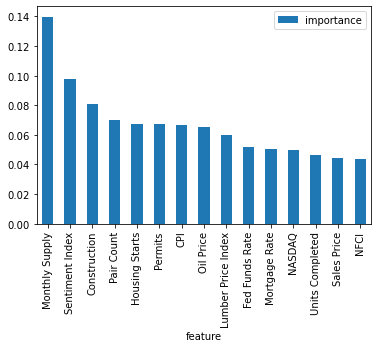

In [24]:
# add the feature importance to a dataframe
feature_importance_df = pd.DataFrame({"feature": feature_list, "importance": importances})
# sort the dataframe by the importance
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# set the index to be the feature
feature_importance_df = feature_importance_df.set_index("feature", drop=True)
# plot the feature importance
feature_importance_df.plot(kind="bar")
plt.show()

In [25]:
# use plotly to create a bar chart of the feature importance
fig = px.bar(feature_importance_df, x=feature_importance_df.index, y="importance", title="Feature Importance", color="importance", color_continuous_scale=px.colors.sequential.Cividis_r)
# save the plot as a png file
fig.write_image("images/feature_importance_custom.png")
# show the plot
fig.show()

In [26]:
# create a confusion matrix
cm = confusion_matrix(y_test, predictions)
# create a dataframe from the confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
# display the confusion matrix
display(cm_df)


,Predicted 0,Predicted 1
Actual 0,19,10
Actual 1,7,72


In [27]:
# print the classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.66      0.69        29
           1       0.88      0.91      0.89        79

    accuracy                           0.84       108
   macro avg       0.80      0.78      0.79       108
weighted avg       0.84      0.84      0.84       108



In [28]:
# define a function to output images of tables
def save_df_as_image(df, filename):
    source = ColumnDataSource(df)
    columns = [TableColumn(field=Ci, title=Ci) for Ci in df.columns]  # bokeh columns
    # add index column
    columns.insert(0, TableColumn(field="index", title="index"))
    # use df index as index column
    source.add(df.index, "index")
    data_table = DataTable(columns=columns, source=source, width=800, height=280)
    export_png(data_table, filename=filename)

In [29]:
# save a table of the feature importance
save_df_as_image(feature_importance_df, "images/feature_importance_custom_table.png")

In [30]:
# save a table of the confusion matrix
save_df_as_image(cm_df, "images/confusion_matrix_custom_table.png")

In [31]:
# save a table of the classification report
classification_report_df = pd.DataFrame(classification_report(y_test, predictions, output_dict=True)).transpose()
save_df_as_image(classification_report_df, "images/classification_report_custom_table.png")